In [1]:
import os
import numpy as np
import sklearn as sk
import h5py
import analyze_tools as at
at.log.set_level("debug")

In [2]:
def get_count_trajectory(fname, cache_fname=None):
    if cache_fname and os.path.exists(cache_fname):
        return np.load(cache_fname)
    else:
        dtraj = []
        if os.path.exists(fname):
            with h5py.File(fname) as f:
                traj = f["readdy/trajectory"]
                traj_time = traj["time"]
                traj_time_records = traj["records"]
                for time, records in zip(traj_time, traj_time_records):
                    current_counts = [0]*4
                    for record in records:
                        type_id = record["typeId"]
                        current_counts[type_id] += 1
                    dtraj.append(current_counts)
        else:
            log.warn("file {} did not exist".format(fname))
        dtraj = np.array(dtraj)
        if cache_fname:
            np.save(cache_fname, dtraj)
        return dtraj
def get_count_trajectory_n_particles_obs(fname, cache_fname=None):
    with h5py.File(fname) as f:
        return f["readdy/observables/n_particles/data"][:].astype(np.double)
def rate_info(xi):
    diffusion_coeff = 0.2 
    micro_rate = 0.05
    reaction_radius = 0.7
    tmp = np.sqrt(micro_rate / diffusion_coeff) * reaction_radius
    rate_chapman = 4. * np.pi * diffusion_coeff * reaction_radius * (1. - np.tanh(tmp) / tmp)
    print("erban chapman rate (per volume): {}".format(rate_chapman))
    print("lasso fitted rate (per counts): {}".format(xi[0]))
    print("lasso fitted rate (per volume): {}".format(xi[0] * 15 * 15 * 15))

In [3]:
counts = get_count_trajectory_n_particles_obs("../generate/simple_trajectory_.h5", cache_fname='counts_traj_2.npy')
counts = counts[:45*500]
n_timesteps = counts.shape[0]
n_species = counts.shape[1]

In [4]:
time_step = .01
dcounts_dt = np.gradient(counts, axis=0) / time_step
print(counts.shape)
print("max counts = {}, min counts = {}".format(np.max(counts), np.min(counts[np.nonzero(counts)])))

(22500, 4)
max counts = 6000.0, min counts = 1.0


# mean field model

In [5]:
theta1 = lambda x: x[:,0]
theta2 = lambda x: x[:,1]
theta3 = lambda x: x[:,2]
theta4 = lambda x: x[:,0]*x[:,1]
theta5 = lambda x: x[:,0]*x[:,2]
theta6 = lambda x: x[:,1]*x[:,2]

In [6]:
theta = np.array([theta1(counts), theta2(counts), theta3(counts), theta4(counts), theta5(counts), theta6(counts)])

In [7]:
# theta in R^(species x ansatz functions * n_timesteps)
print(theta.shape)

(6, 22500)


In [8]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1, positive=True)
clf.fit(theta.T, dcounts_dt)

/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=True, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [9]:
print(dcounts_dt.shape)
print(theta.shape)

(22500, 4)
(6, 22500)


In [10]:
print(clf.coef_)

[[  0.00000000e+00   1.52710319e-03   4.17277367e-02   0.00000000e+00
    0.00000000e+00   2.36129711e-06]
 [  0.00000000e+00   2.02706679e-03   1.87372129e-02   0.00000000e+00
    0.00000000e+00   2.54752868e-06]
 [  0.00000000e+00   0.00000000e+00   9.97954521e-04   1.99521901e-06
    2.33441241e-07   0.00000000e+00]
 [  6.92966038e-03   0.00000000e+00   4.06133077e-03   1.01537467e-06
    1.38117609e-07   3.51125178e-07]]


# Averaging: solve for all times indepdenently

In [11]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=15, warm_start=False, max_iter=1000, tol=1e-6, positive=True)

In [12]:
theta1 = lambda x: np.array([-x[0]*x[1], -x[0]*x[1], x[0]*x[1], 0])
theta2 = lambda x: np.array([x[2], x[2], -x[2], 0])
theta3 = lambda x: np.array([-x[0], x[0], 0, 0])
theta5 = lambda x: np.array([-x[0], 0, 0, x[0]])
alphas = []
for i in range(0, n_timesteps):
    c = counts[i]
    theta = np.array([theta1(c), theta2(c), theta3(c), theta5(c)])
    dc = dcounts_dt[i]
    clf.fit(theta.T, dc)
    alphas.append(clf.coef_)
xi = np.sum(alphas, axis=0) / len(alphas)
print("xi = %s" % xi)

xi = [  1.70342302e-06   0.00000000e+00   0.00000000e+00   1.03512901e-02]


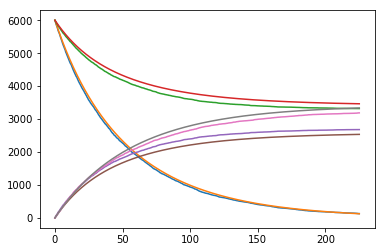

In [13]:
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
def fun(data, _):
    theta = np.array([theta1(data), theta2(data), theta3(data), theta5(data)])
    return np.matmul(xi, theta)
num_solution = odeint(fun, counts[0], np.arange(0, n_timesteps*.01, .01))
for i in range(4):
    plt.plot(np.arange(0, n_timesteps*.01, .01), counts[:,i])
    plt.plot(np.arange(0, n_timesteps*.01, .01), num_solution[:, i])

# Frobenius norm with L1 penalty regression

In [14]:
theta1 = lambda x: np.array([-x[:,0]*x[:,1], -x[:,0]*x[:,1], x[:,0]*x[:,1], np.zeros(n_timesteps)])
theta2 = lambda x: np.array([x[:,2], x[:,2], -x[:,2], np.zeros(n_timesteps)])
theta3 = lambda x: np.array([-x[:,0], x[:,0], np.zeros(n_timesteps), np.zeros(n_timesteps)])
theta4 = lambda x: np.array([-x[:,0], np.zeros(n_timesteps), np.zeros(n_timesteps), x[:,0]])
theta5 = lambda x: np.array([x[:,3], np.zeros(n_timesteps), np.zeros(n_timesteps), -x[:,3]])
thetas = [theta1, theta2, theta3, theta4, theta5]
n_basis_functions = len(thetas)
theta1_ode = lambda x: np.array([-x[0]*x[1], -x[0]*x[1], x[0]*x[1], 0])
theta2_ode = lambda x: np.array([x[2], x[2], -x[2], 0])
theta3_ode = lambda x: np.array([-x[0], x[0], 0, 0])
theta4_ode = lambda x: np.array([-x[0], 0, 0, x[0]])
theta5_ode = lambda x: np.array([x[3], 0, 0, -x[3]])
thetas_ode = [theta1_ode, theta2_ode, theta3_ode, theta4_ode, theta5_ode]

In [15]:
large_theta = np.array([f(counts) for f in thetas])
large_theta = np.transpose(large_theta, axes=((2, 0, 1)))

In [16]:
large_theta.shape

(22500, 5, 4)

In [39]:
def frob_l1_regression(theta, dcounts_dt, alpha):
    import scipy.optimize as so

    bounds = [(0., None)]*n_basis_functions
    init_xi = np.array([5.] * n_basis_functions)
    iterations = []
    result = so.minimize(
        lambda x: at.lasso_minimizer_objective_fun(x, alpha, theta/(4.*n_timesteps), dcounts_dt/(4.*n_timesteps)), 
        init_xi,
        bounds=bounds, 
        callback=lambda x: iterations.append(x),
        tol=1e-16,
        method='L-BFGS-B')
    return result.x
xi = frob_l1_regression(large_theta, dcounts_dt, .001)
print("coefficients: {}".format(xi))

coefficients: [  1.92366738e-06   0.00000000e+00   0.00000000e+00   1.02183653e-02
   1.57494383e-05]


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint

def fun(data, _):
    theta = np.array([f(data) for f in thetas_ode])
    return np.matmul(xi, theta)

num_solution = odeint(fun, counts[0], np.arange(0, n_timesteps*.01, .01))

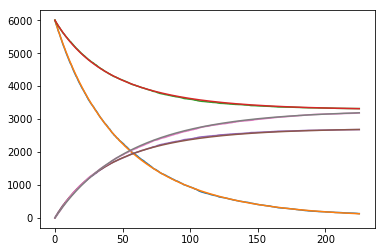

In [19]:
for i in range(n_species):
    plt.plot(np.arange(0, n_timesteps*.01, .01), counts[:,i])
    plt.plot(np.arange(0, n_timesteps*.01, .01), num_solution[:, i])

# cross validation

In [79]:
theta1 = lambda x: np.array([-x[:,0]*x[:,1], -x[:,0]*x[:,1], x[:,0]*x[:,1], np.zeros(x.shape[0])])
theta2 = lambda x: np.array([x[:,2], x[:,2], -x[:,2], np.zeros(x.shape[0])])
theta3 = lambda x: np.array([-x[:,0], x[:,0], np.zeros(x.shape[0]), np.zeros(x.shape[0])])
theta4 = lambda x: np.array([-x[:,0], np.zeros(x.shape[0]), np.zeros(x.shape[0]), x[:,0]])
theta5 = lambda x: np.array([x[:,3], np.zeros(x.shape[0]), np.zeros(x.shape[0]), -x[:,3]])
thetas = [theta1, theta2, theta3, theta4, theta5]
n_basis_functions = len(thetas)

In [86]:
training_data, test_data = counts[:3000][:], counts[3000:][:]
dtraining_data_dt = np.gradient(training_data, axis=0) / time_step
dtest_data_dt = np.gradient(test_data, axis=0) / time_step

In [119]:
from ipywidgets import FloatProgress
from IPython.display import display
coefficients = []
alphas = np.arange(0, .4, .0005)
large_theta = np.array([f(training_data) for f in thetas])
large_theta = np.transpose(large_theta, axes=((2, 0, 1)))
f = FloatProgress(min=np.min(alphas), max=np.max(alphas))
display(f)
for alpha in alphas:
    xi = frob_l1_regression(large_theta, dtraining_data_dt, alpha)
    f.value = alpha
    coefficients.append(xi)

In [120]:
large_theta_test = np.array([f(test_data) for f in thetas])
large_theta_test = np.transpose(large_theta_test, axes=((2, 0, 1)))
cost_learn = []
cost_test = []
for coeff in coefficients:
    cost_learn.append(at.lasso_minimizer_objective_fun(coeff, 0.0, large_theta/(4.*n_timesteps), dtraining_data_dt/(4.*n_timesteps)))
    cost_test.append(at.lasso_minimizer_objective_fun(coeff, 0.0, large_theta_test/(4.*n_timesteps), dtest_data_dt/(4.*n_timesteps)))

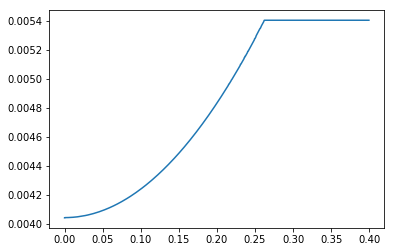

23

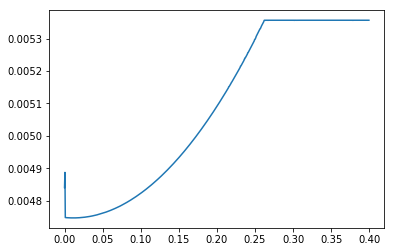

In [123]:
plt.plot(alphas, np.array(cost_learn), label="train")
ymin, ymax = plt.ylim()
# plt.ylim((ymin, 0.0079209))
plt.show()
plt.plot(alphas, np.array(cost_test), label="test")
np.argmin(np.array(cost_test))
# plt.ylim((0.00474, 0.0048))

(0, 0.0115)

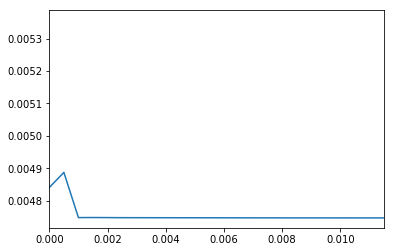

In [127]:
plt.plot(alphas, np.array(cost_test))
plt.xlim(0, 0.0115)

In [124]:
cost_test[23]

0.004746581875575834

In [126]:
cost_test[0] - cost_test[23]

9.39389401739682e-05

In [145]:
import scipy.optimize as so

def minimizer(current_alpha):
    xi = frob_l1_regression(large_theta, dtraining_data_dt, alpha)
    x = at.lasso_minimizer_objective_fun(xi, alpha, large_theta_test/(4.*n_timesteps), dtest_data_dt/(4.*n_timesteps))
    return x
    
result = so.minimize_scalar(
        minimizer,
        bounds=(0, .2),
        method="bounded")
print(result.x)

0.19999516503
